In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import shap
import graphviz
import xgboost as xgb
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

In [2]:
full_df = pd.read_csv('processed_data.csv')

In [3]:
full_df

,ACTOR,ROLE,TITLE,AWARD,SCORE_1,SCORE_2,NUM_REVIEWS,polarity_mean,objectivity_mean,NUMERIC_KEY
0,Adam Driver,charlie barber,marriage story,1.0,85.0,94.0,48.0,0.190969,0.479507,0
1,Adolphe Menjou,walter burns,the front page,1.0,60.0,93.0,1.0,0.500000,1.000000,1
2,Adrien Brody,wladyslaw szpilman,the pianist,2.0,96.0,95.0,40.0,0.128576,0.603966,2
3,Al Pacino,frank serpico,serpico,1.0,88.0,90.0,6.0,0.238542,0.572917,3
4,Al Pacino,michael corleone,the godfather part ii,1.0,97.0,98.0,17.0,0.380286,0.646926,3
...,...,...,...,...,...,...,...,...,...,...
14469,Max von Sydow,director,rosamunde pilchner two sisters,0.0,0.0,0.0,0.0,0.000000,0.000000,141
14470,Max von Sydow,narrator,europa,0.0,89.0,80.0,2.0,0.500000,0.562500,141
14471,Max von Sydow,director,katinka,0.0,0.0,0.0,0.0,0.000000,0.000000,141
14472,Ralph Fiennes,narrator,andre the voice of wine,0.0,0.0,0.0,0.0,0.000000,0.000000,169


In [4]:
exclude_roles = ['director','producer','executive producer','narrator','host','writer','original music', 'music','screenwriter']
full_df = full_df[~full_df.ROLE.isin(exclude_roles)]

## Extra Filtering:

Should Leonardo DiCaprio have won the award for Best Actor for one of his earlier performances? At the heart of this question lies another: "Can the award for Best Actor be accurately predicted?" After cleaning and preparing the data set, further filtering was needed. This was done to ensure that the data contains only films where the actor is credited with portraying a character and not a 'non-perfomance' role such as a director, a narrator, a host, or a composer.

In [5]:
full_df

,ACTOR,ROLE,TITLE,AWARD,SCORE_1,SCORE_2,NUM_REVIEWS,polarity_mean,objectivity_mean,NUMERIC_KEY
0,Adam Driver,charlie barber,marriage story,1.0,85.0,94.0,48.0,0.190969,0.479507,0
1,Adolphe Menjou,walter burns,the front page,1.0,60.0,93.0,1.0,0.500000,1.000000,1
2,Adrien Brody,wladyslaw szpilman,the pianist,2.0,96.0,95.0,40.0,0.128576,0.603966,2
3,Al Pacino,frank serpico,serpico,1.0,88.0,90.0,6.0,0.238542,0.572917,3
4,Al Pacino,michael corleone,the godfather part ii,1.0,97.0,98.0,17.0,0.380286,0.646926,3
...,...,...,...,...,...,...,...,...,...,...
13911,Terrence Howard,jimmy,best laid plans,0.0,38.0,43.0,5.0,1.000000,0.300000,206
13912,Terrence Howard,dexter banks,butter,0.0,0.0,0.0,0.0,0.000000,0.000000,206
13913,Terrence Howard,jimmy the warlock,johns,0.0,58.0,54.0,2.0,-0.107143,0.517857,206
13914,Terrence Howard,spaceman,sunset park,0.0,83.0,13.0,3.0,0.336111,0.491667,206


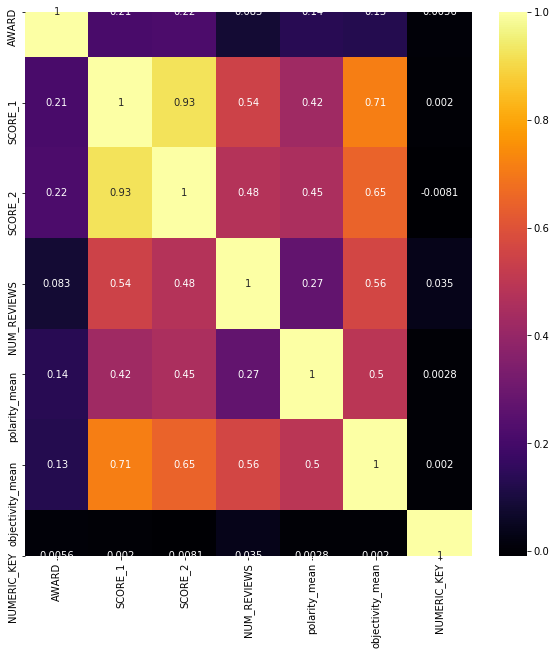

In [6]:
plt.figure(figsize=(10,10))
c = full_df.corr(method='pearson')
sns.heatmap(c,cmap='inferno',annot=True)

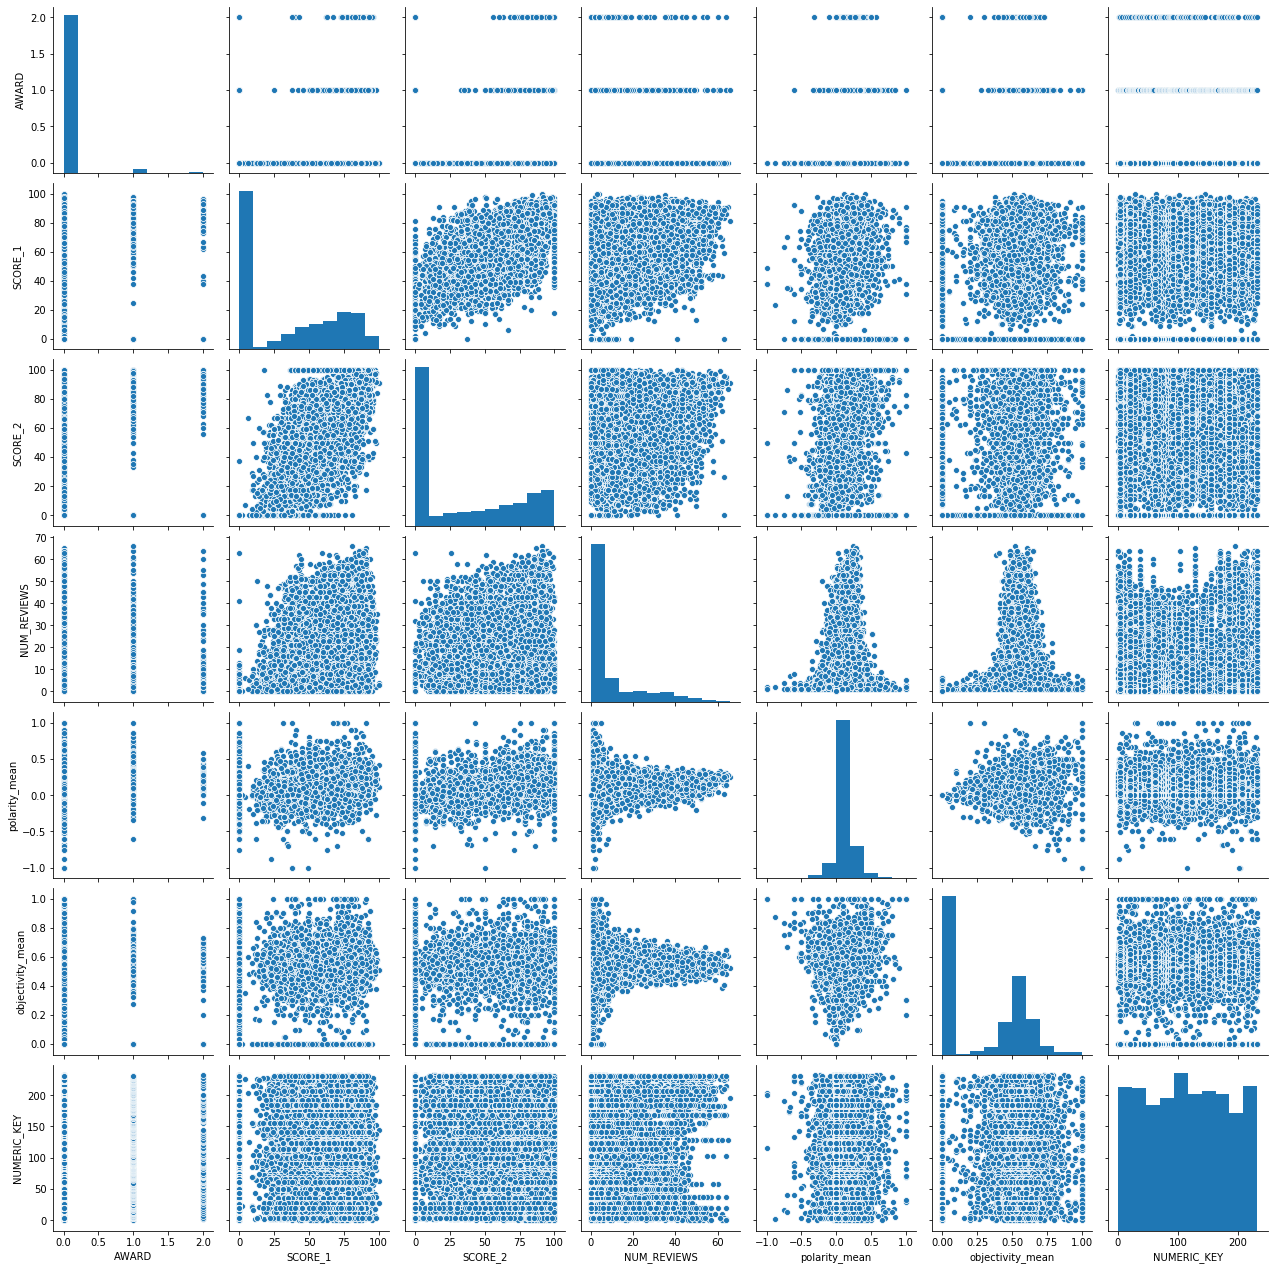

In [7]:
sns.pairplot(data=full_df)

In [7]:
full_df.AWARD.value_counts()

0.0    13370
1.0      363
2.0       92
Name: AWARD, dtype: int64

## Visual information:

The correlation matrix shows moderate values for all features present in the data set save for AWARD and NUMERIC_KEY. Of the features present the highest correlation score is that for SCORE_1 and SCORE_2 suggesting that critics and audience are much more likely to rate a movie with comparable scores. Furthermore, we see a higher correlation score between SCORE_1, NUM_REVIEWS and OBJECTIVITY--subjectivity. This makes sense as the reviews analyzed here are specifically those from critics that have reviewed the films. Interestingly enough, there is a slight improvement in score between POLARITY--pos/neg sentiment--and SCORE_2 which might indicate that a reviewer's language is more indicative of their true feelings towards a movie--cannot substantiate this claim at this moment.

The most important fact gathered from the pairplot is the highly imbalanced nature of the target class AWARD with >1% of the data comprising oscar winners and ~2.6% of the data comprising oscar nominations which leaves ~96% of the data as films in which all oscar winners or nominees have not had performances worth noting--from the perspective of the Academy. It is also important to note that this does not take into consideration performances for which an actor received a nomination in another acting category such as best supporting.


In [6]:
def balancedWeights(label_set):
    classes = label_set.unique()
    classes.sort()
    class_weights = list(class_weight.compute_class_weight('balanced',
                                                           np.unique(label_set),
                                                           label_set.values))
    
    cw_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
    cw_array = [cw_dict[i] for i in label_set.values]
    return cw_array

To account for the imbalance in the data, a vector containing the weights for the labels is used to fit the cross validation training for both random and grid search, as well as for training subsequent models.

In [7]:
X = full_df[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']]
y = full_df['AWARD']

X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size = 0.25, random_state=121)
y0_weights = balancedWeights(y_tr)

Pass classes=[0. 1. 2.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [59]:
param_search1 = {
    'min_child_weight': [2,4,8,10,12],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0],
    'subsample' : [0.5,0.6,0.7,0.8,0.9],
    'max_depth': [3,4,5,6,7,8,9,10],
}

base_clf = xgb.XGBClassifier(learning_rate=0.1,n_estimators=1000, objective='multi:softmax', num_class=3)

rand_search1 = RandomizedSearchCV(base_clf, param_search1,
                             scoring='roc_auc_ovo', n_jobs=4,
                             cv=5)
rand_search1.fit(X_tr,y_tr, sample_weight = y0_weights)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=1000,...
                                           objective='multi:softmax',
                                           random_state=None, reg_alpha=None,
                                 

In [60]:
print('\n All results:')
print(rand_search1.cv_results_)
print('\n Best estimator:')
print(rand_search1.best_estimator_)
print('\n Best hyperparameters:')
print(rand_search1.best_params_)


 All results:
{'mean_fit_time': array([24.92865372, 22.55513091, 12.7459703 , 16.75051508, 26.14750538,
       19.45902691, 24.50056257, 27.44401479, 14.68062177, 20.83296447]), 'std_fit_time': array([0.71267447, 0.34835771, 0.15441867, 0.25435673, 0.45510933,
       0.1128052 , 0.260308  , 0.28629066, 0.08354832, 2.49878784]), 'mean_score_time': array([1.10384722, 1.19185853, 0.46205392, 0.81067481, 1.02276354,
       0.61489573, 0.95536919, 0.94006953, 0.40995927, 0.82183299]), 'std_score_time': array([0.05774551, 0.13740183, 0.04765233, 0.1335549 , 0.06939867,
       0.02990532, 0.02027803, 0.03393034, 0.02176135, 0.17404058]), 'param_subsample': masked_array(data=[0.8, 0.8, 0.9, 0.5, 0.8, 0.7, 0.8, 0.7, 0.6, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[8, 4, 4, 12, 2, 4, 2, 4, 8, 8],
             mask=[False, False, Fa

In [67]:
model_1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=8, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_1.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.27797	validation_1-merror:0.27567
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.24499	validation_1-merror:0.24761
[2]	validation_0-merror:0.26302	validation_1-merror:0.26179
[3]	validation_0-merror:0.25781	validation_1-merror:0.25195
[4]	validation_0-merror:0.24306	validation_1-merror:0.23836
[5]	validation_0-merror:0.24711	validation_1-merror:0.24414
[6]	validation_0-merror:0.23862	validation_1-merror:0.23402
[7]	validation_0-merror:0.23727	validation_1-merror:0.23604
[8]	validation_0-merror:0.23216	validation_1-merror:0.23084
[9]	validation_0-merror:0.22425	validation_1-merror:0.22418
[10]	validation_0-merror:0.22029	validation_1-merror:0.22042
[11]	validation_0-merror:0.21914	validation_1-merror:0.21753
[12]	validation_0-merror:0.21586	validation_1-merror:0.21377
[13]	validation_0-merror:0.21981	validation_1-merror:0

[132]	validation_0-merror:0.17949	validation_1-merror:0.19497
[133]	validation_0-merror:0.18046	validation_1-merror:0.19612
[134]	validation_0-merror:0.17901	validation_1-merror:0.19526
[135]	validation_0-merror:0.17776	validation_1-merror:0.19497
[136]	validation_0-merror:0.17853	validation_1-merror:0.19584
[137]	validation_0-merror:0.17757	validation_1-merror:0.19526
[138]	validation_0-merror:0.17718	validation_1-merror:0.19468
[139]	validation_0-merror:0.17650	validation_1-merror:0.19381
[140]	validation_0-merror:0.17602	validation_1-merror:0.19468
[141]	validation_0-merror:0.17689	validation_1-merror:0.19381
[142]	validation_0-merror:0.17612	validation_1-merror:0.19352
[143]	validation_0-merror:0.17573	validation_1-merror:0.19381
[144]	validation_0-merror:0.17544	validation_1-merror:0.19236
[145]	validation_0-merror:0.17429	validation_1-merror:0.19092
[146]	validation_0-merror:0.17419	validation_1-merror:0.19063
[147]	validation_0-merror:0.17400	validation_1-merror:0.19092
[148]	va

[265]	validation_0-merror:0.14651	validation_1-merror:0.16546
[266]	validation_0-merror:0.14680	validation_1-merror:0.16575
[267]	validation_0-merror:0.14632	validation_1-merror:0.16546
[268]	validation_0-merror:0.14651	validation_1-merror:0.16517
[269]	validation_0-merror:0.14661	validation_1-merror:0.16459
[270]	validation_0-merror:0.14603	validation_1-merror:0.16488
[271]	validation_0-merror:0.14603	validation_1-merror:0.16430
[272]	validation_0-merror:0.14583	validation_1-merror:0.16401
[273]	validation_0-merror:0.14545	validation_1-merror:0.16401
[274]	validation_0-merror:0.14497	validation_1-merror:0.16430
[275]	validation_0-merror:0.14410	validation_1-merror:0.16257
[276]	validation_0-merror:0.14410	validation_1-merror:0.16286
[277]	validation_0-merror:0.14342	validation_1-merror:0.16315
[278]	validation_0-merror:0.14352	validation_1-merror:0.16315
[279]	validation_0-merror:0.14361	validation_1-merror:0.16344
[280]	validation_0-merror:0.14313	validation_1-merror:0.16170
[281]	va

[398]	validation_0-merror:0.12105	validation_1-merror:0.14810
[399]	validation_0-merror:0.12105	validation_1-merror:0.14810
[400]	validation_0-merror:0.12056	validation_1-merror:0.14637
[401]	validation_0-merror:0.12076	validation_1-merror:0.14695
[402]	validation_0-merror:0.12047	validation_1-merror:0.14550
[403]	validation_0-merror:0.12037	validation_1-merror:0.14579
[404]	validation_0-merror:0.12066	validation_1-merror:0.14579
[405]	validation_0-merror:0.12066	validation_1-merror:0.14579
[406]	validation_0-merror:0.12047	validation_1-merror:0.14579
[407]	validation_0-merror:0.12076	validation_1-merror:0.14579
[408]	validation_0-merror:0.12018	validation_1-merror:0.14521
[409]	validation_0-merror:0.11989	validation_1-merror:0.14463
[410]	validation_0-merror:0.12105	validation_1-merror:0.14463
[411]	validation_0-merror:0.12143	validation_1-merror:0.14463
[412]	validation_0-merror:0.12143	validation_1-merror:0.14550
[413]	validation_0-merror:0.12085	validation_1-merror:0.14550
[414]	va

[531]	validation_0-merror:0.10417	validation_1-merror:0.13104
[532]	validation_0-merror:0.10446	validation_1-merror:0.13075
[533]	validation_0-merror:0.10426	validation_1-merror:0.13046
[534]	validation_0-merror:0.10388	validation_1-merror:0.13162
[535]	validation_0-merror:0.10513	validation_1-merror:0.13277
[536]	validation_0-merror:0.10590	validation_1-merror:0.13306
[537]	validation_0-merror:0.10513	validation_1-merror:0.13335
[538]	validation_0-merror:0.10098	validation_1-merror:0.12757
[539]	validation_0-merror:0.10060	validation_1-merror:0.12757
[540]	validation_0-merror:0.09983	validation_1-merror:0.12786
[541]	validation_0-merror:0.09963	validation_1-merror:0.12843
[542]	validation_0-merror:0.10214	validation_1-merror:0.13162
[543]	validation_0-merror:0.10185	validation_1-merror:0.13133
[544]	validation_0-merror:0.10147	validation_1-merror:0.12901
[545]	validation_0-merror:0.10127	validation_1-merror:0.12959
[546]	validation_0-merror:0.10069	validation_1-merror:0.12901
[547]	va

[664]	validation_0-merror:0.09230	validation_1-merror:0.12323
[665]	validation_0-merror:0.09288	validation_1-merror:0.12323
[666]	validation_0-merror:0.09269	validation_1-merror:0.12294
[667]	validation_0-merror:0.09269	validation_1-merror:0.12236
[668]	validation_0-merror:0.09346	validation_1-merror:0.12352
[669]	validation_0-merror:0.09037	validation_1-merror:0.12207
[670]	validation_0-merror:0.09057	validation_1-merror:0.12207
[671]	validation_0-merror:0.08999	validation_1-merror:0.12149
[672]	validation_0-merror:0.08970	validation_1-merror:0.12178
[673]	validation_0-merror:0.08960	validation_1-merror:0.12149
[674]	validation_0-merror:0.09230	validation_1-merror:0.12236
[675]	validation_0-merror:0.09221	validation_1-merror:0.12265
[676]	validation_0-merror:0.09250	validation_1-merror:0.12265
[677]	validation_0-merror:0.09259	validation_1-merror:0.12207
[678]	validation_0-merror:0.09269	validation_1-merror:0.12265
[679]	validation_0-merror:0.09317	validation_1-merror:0.12438
[680]	va

[797]	validation_0-merror:0.07870	validation_1-merror:0.11513
[798]	validation_0-merror:0.07986	validation_1-merror:0.11686
[799]	validation_0-merror:0.07996	validation_1-merror:0.11629
[800]	validation_0-merror:0.07938	validation_1-merror:0.11542
[801]	validation_0-merror:0.08266	validation_1-merror:0.11657
[802]	validation_0-merror:0.07870	validation_1-merror:0.11368
[803]	validation_0-merror:0.07784	validation_1-merror:0.11310
[804]	validation_0-merror:0.07726	validation_1-merror:0.11339
[805]	validation_0-merror:0.08131	validation_1-merror:0.11571
[806]	validation_0-merror:0.07784	validation_1-merror:0.11513
[807]	validation_0-merror:0.08034	validation_1-merror:0.11600
[808]	validation_0-merror:0.07716	validation_1-merror:0.11426
[809]	validation_0-merror:0.07658	validation_1-merror:0.11339
[810]	validation_0-merror:0.07745	validation_1-merror:0.11397
[811]	validation_0-merror:0.07562	validation_1-merror:0.11079
[812]	validation_0-merror:0.07581	validation_1-merror:0.11079
[813]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
tr_pred1 = model_1.predict(X_tr)
tr_prob1 = model_1.predict_proba(X_tr)
te_pred1 = model_1.predict(X_te)
te_prob1 = model_1.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred1)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob1, average='weighted',multi_class='ovo')))
print( "Accuracy Score (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred1)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob1, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 95.73%
AUC Score (Train): 0.9939
Accuracy Score (Test): 45.57%
AUC Score (Train): 0.8123


In [69]:
model_1.set_params(n_estimators=811)
param_search2 = {
    'min_child_weight': [7,8,9],
    'max_depth': [3,4,5],
    'subsample': [0.5,0.6,0.7],
    'colsample_bytree': [0.8,0.9,1.0]
    }

grid_search2 = GridSearchCV(model_1, param_search2, scoring='roc_auc_ovo',
                           n_jobs=4, cv=5)
grid_search2.fit(X_tr,y_tr, sample_weight=y0_weights)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=8,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=811, n_jobs=0, num_class=3,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=0.6,
                                     tree_method='

In [70]:
print('\n All results:')
print(grid_search2.cv_results_)
print('\n Best estimator:')
print(grid_search2.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search2.best_params_)


 All results:
{'mean_fit_time': array([11.82768607, 11.03943467, 10.72749753, 10.8386909 , 10.84375353,
       10.72534289, 10.82991071, 10.8739295 , 10.86470652, 12.86218185,
       13.0489944 , 12.96096272, 12.88009629, 13.08773603, 13.10649309,
       14.00186419, 14.91842408, 14.61433177, 14.96056581, 14.82474389,
       14.86253886, 15.1367579 , 15.65103588, 15.21727796, 14.72890501,
       16.3160634 , 15.3351274 , 12.44367332, 12.63243303, 12.25577707,
       12.38927994, 12.49926085, 12.32512207, 12.61057177, 12.36024566,
       12.03392963, 14.76849403, 15.10125957, 14.59205542, 14.85904512,
       15.89091616, 14.5488462 , 14.19525986, 14.37694459, 14.23408813,
       16.14900513, 16.8936676 , 18.04666581, 16.9584465 , 16.94102387,
       16.8283309 , 17.04716258, 16.67801266, 16.66019411, 13.22240362,
       13.36491733, 13.38058367, 13.14558926, 13.36663537, 13.34794517,
       13.13632255, 13.07387671, 13.17379479, 16.14736834, 16.09658728,
       16.33401246, 15.72146111

In [77]:
model_2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=811, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_2.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.26292	validation_1-merror:0.26294
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.26707	validation_1-merror:0.26150
[2]	validation_0-merror:0.25984	validation_1-merror:0.25629
[3]	validation_0-merror:0.24952	validation_1-merror:0.24472
[4]	validation_0-merror:0.23341	validation_1-merror:0.22621
[5]	validation_0-merror:0.23428	validation_1-merror:0.22621
[6]	validation_0-merror:0.22637	validation_1-merror:0.22100
[7]	validation_0-merror:0.22492	validation_1-merror:0.22013
[8]	validation_0-merror:0.21904	validation_1-merror:0.21608
[9]	validation_0-merror:0.21557	validation_1-merror:0.21464
[10]	validation_0-merror:0.21711	validation_1-merror:0.21348
[11]	validation_0-merror:0.21460	validation_1-merror:0.21117
[12]	validation_0-merror:0.21132	validation_1-merror:0.21059
[13]	validation_0-merror:0.21161	validation_1-merror:0

[132]	validation_0-merror:0.17699	validation_1-merror:0.18745
[133]	validation_0-merror:0.17834	validation_1-merror:0.18802
[134]	validation_0-merror:0.17699	validation_1-merror:0.18745
[135]	validation_0-merror:0.17564	validation_1-merror:0.18600
[136]	validation_0-merror:0.17650	validation_1-merror:0.18658
[137]	validation_0-merror:0.17525	validation_1-merror:0.18629
[138]	validation_0-merror:0.17544	validation_1-merror:0.18542
[139]	validation_0-merror:0.17506	validation_1-merror:0.18542
[140]	validation_0-merror:0.17419	validation_1-merror:0.18311
[141]	validation_0-merror:0.17467	validation_1-merror:0.18513
[142]	validation_0-merror:0.17409	validation_1-merror:0.18426
[143]	validation_0-merror:0.17448	validation_1-merror:0.18426
[144]	validation_0-merror:0.17342	validation_1-merror:0.18195
[145]	validation_0-merror:0.17352	validation_1-merror:0.18166
[146]	validation_0-merror:0.17265	validation_1-merror:0.18253
[147]	validation_0-merror:0.17188	validation_1-merror:0.18137
[148]	va

[265]	validation_0-merror:0.14786	validation_1-merror:0.16778
[266]	validation_0-merror:0.14824	validation_1-merror:0.16893
[267]	validation_0-merror:0.14834	validation_1-merror:0.16720
[268]	validation_0-merror:0.14834	validation_1-merror:0.16835
[269]	validation_0-merror:0.14873	validation_1-merror:0.16864
[270]	validation_0-merror:0.14815	validation_1-merror:0.16806
[271]	validation_0-merror:0.14757	validation_1-merror:0.16806
[272]	validation_0-merror:0.14699	validation_1-merror:0.16778
[273]	validation_0-merror:0.14757	validation_1-merror:0.16662
[274]	validation_0-merror:0.14651	validation_1-merror:0.16633
[275]	validation_0-merror:0.14458	validation_1-merror:0.16430
[276]	validation_0-merror:0.14419	validation_1-merror:0.16459
[277]	validation_0-merror:0.14352	validation_1-merror:0.16430
[278]	validation_0-merror:0.14371	validation_1-merror:0.16344
[279]	validation_0-merror:0.14342	validation_1-merror:0.16373
[280]	validation_0-merror:0.14342	validation_1-merror:0.16286
[281]	va

[398]	validation_0-merror:0.12346	validation_1-merror:0.14492
[399]	validation_0-merror:0.12384	validation_1-merror:0.14377
[400]	validation_0-merror:0.12365	validation_1-merror:0.14406
[401]	validation_0-merror:0.12288	validation_1-merror:0.14463
[402]	validation_0-merror:0.12249	validation_1-merror:0.14463
[403]	validation_0-merror:0.12404	validation_1-merror:0.14579
[404]	validation_0-merror:0.12394	validation_1-merror:0.14579
[405]	validation_0-merror:0.12442	validation_1-merror:0.14695
[406]	validation_0-merror:0.12288	validation_1-merror:0.14521
[407]	validation_0-merror:0.12461	validation_1-merror:0.14695
[408]	validation_0-merror:0.12539	validation_1-merror:0.14810
[409]	validation_0-merror:0.12519	validation_1-merror:0.14724
[410]	validation_0-merror:0.12452	validation_1-merror:0.14695
[411]	validation_0-merror:0.12413	validation_1-merror:0.14666
[412]	validation_0-merror:0.12384	validation_1-merror:0.14753
[413]	validation_0-merror:0.12365	validation_1-merror:0.14608
[414]	va

[531]	validation_0-merror:0.10532	validation_1-merror:0.13248
[532]	validation_0-merror:0.10475	validation_1-merror:0.13162
[533]	validation_0-merror:0.10455	validation_1-merror:0.13075
[534]	validation_0-merror:0.10446	validation_1-merror:0.12959
[535]	validation_0-merror:0.10494	validation_1-merror:0.13017
[536]	validation_0-merror:0.10571	validation_1-merror:0.13075
[537]	validation_0-merror:0.10822	validation_1-merror:0.13248
[538]	validation_0-merror:0.10552	validation_1-merror:0.13075
[539]	validation_0-merror:0.10012	validation_1-merror:0.12525
[540]	validation_0-merror:0.10012	validation_1-merror:0.12496
[541]	validation_0-merror:0.09954	validation_1-merror:0.12467
[542]	validation_0-merror:0.09857	validation_1-merror:0.12496
[543]	validation_0-merror:0.10204	validation_1-merror:0.12988
[544]	validation_0-merror:0.10195	validation_1-merror:0.12988
[545]	validation_0-merror:0.10233	validation_1-merror:0.12988
[546]	validation_0-merror:0.10272	validation_1-merror:0.12930
[547]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=811, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
tr_pred2 = model_2.predict(X_tr)
tr_prob2 = model_2.predict_proba(X_tr)
te_pred2 = model_2.predict(X_te)
te_prob2 = model_2.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred2)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob2, average='weighted',multi_class='ovo')))
print( "Accuracy Score (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred2)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob2, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 94.34%
AUC Score (Train): 0.9872
Accuracy Score (Test): 48.65%
AUC Score (Train): 0.8262


In [79]:
model_2.set_params(n_estimators=541)
param_search3 = {
    'gamma': [i/10 for i in range(0,6)]
}

grid_search3 = GridSearchCV(model_2, param_search3, scoring='roc_auc_ovo',
                           n_jobs=4, cv=5)
grid_search3.fit(X_tr,y_tr, sample_weight=y0_weights)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=9,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=541, n_jobs=0, num_class=3,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=0.5,
                                     tree_method='

In [80]:
print('\n All results:')
print(grid_search3.cv_results_)
print('\n Best estimator:')
print(grid_search3.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search3.best_params_)


 All results:
{'mean_fit_time': array([8.02458744, 8.0806282 , 7.8404563 , 7.85463953, 8.05699763,
       6.78539782]), 'std_fit_time': array([0.07569191, 0.21966636, 0.03368442, 0.03202821, 0.07202582,
       1.42750017]), 'mean_score_time': array([0.23712487, 0.21290464, 0.21561918, 0.21272025, 0.21026602,
       0.18857675]), 'std_score_time': array([0.03689342, 0.01340931, 0.00845746, 0.00351835, 0.00256072,
       0.03271818]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}], 'split0_test_score': array([0.74995107, 0.75409294, 0.75186753, 0.74386098, 0.7440175 ,
       0.74615658]), 'split1_test_score': array([0.73002588, 0.7223708 , 0.72655084, 0.72791012, 0.72277659,
       0.71861602]), 'split2_test_score': array([0.74902991, 0.75255822, 0.75072

In [81]:
model_3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

model_3.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.26292	validation_1-merror:0.26294
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.26707	validation_1-merror:0.26150
[2]	validation_0-merror:0.25984	validation_1-merror:0.25629
[3]	validation_0-merror:0.24952	validation_1-merror:0.24472
[4]	validation_0-merror:0.23341	validation_1-merror:0.22621
[5]	validation_0-merror:0.23428	validation_1-merror:0.22621
[6]	validation_0-merror:0.22637	validation_1-merror:0.22100
[7]	validation_0-merror:0.22492	validation_1-merror:0.22013
[8]	validation_0-merror:0.21904	validation_1-merror:0.21608
[9]	validation_0-merror:0.21557	validation_1-merror:0.21464
[10]	validation_0-merror:0.21711	validation_1-merror:0.21348
[11]	validation_0-merror:0.21460	validation_1-merror:0.21117
[12]	validation_0-merror:0.21132	validation_1-merror:0.21059
[13]	validation_0-merror:0.21161	validation_1-merror:0

[132]	validation_0-merror:0.17892	validation_1-merror:0.18802
[133]	validation_0-merror:0.17988	validation_1-merror:0.18860
[134]	validation_0-merror:0.17882	validation_1-merror:0.18687
[135]	validation_0-merror:0.17824	validation_1-merror:0.18716
[136]	validation_0-merror:0.17940	validation_1-merror:0.18860
[137]	validation_0-merror:0.17786	validation_1-merror:0.18831
[138]	validation_0-merror:0.17747	validation_1-merror:0.18860
[139]	validation_0-merror:0.17679	validation_1-merror:0.18745
[140]	validation_0-merror:0.17660	validation_1-merror:0.18571
[141]	validation_0-merror:0.17699	validation_1-merror:0.18600
[142]	validation_0-merror:0.17573	validation_1-merror:0.18340
[143]	validation_0-merror:0.17612	validation_1-merror:0.18397
[144]	validation_0-merror:0.17593	validation_1-merror:0.18484
[145]	validation_0-merror:0.17515	validation_1-merror:0.18542
[146]	validation_0-merror:0.17525	validation_1-merror:0.18600
[147]	validation_0-merror:0.17322	validation_1-merror:0.18426
[148]	va

[265]	validation_0-merror:0.14468	validation_1-merror:0.16575
[266]	validation_0-merror:0.14487	validation_1-merror:0.16575
[267]	validation_0-merror:0.14458	validation_1-merror:0.16633
[268]	validation_0-merror:0.14497	validation_1-merror:0.16546
[269]	validation_0-merror:0.14477	validation_1-merror:0.16604
[270]	validation_0-merror:0.14400	validation_1-merror:0.16575
[271]	validation_0-merror:0.14410	validation_1-merror:0.16459
[272]	validation_0-merror:0.14381	validation_1-merror:0.16546
[273]	validation_0-merror:0.14342	validation_1-merror:0.16488
[274]	validation_0-merror:0.14294	validation_1-merror:0.16546
[275]	validation_0-merror:0.14197	validation_1-merror:0.16373
[276]	validation_0-merror:0.14188	validation_1-merror:0.16286
[277]	validation_0-merror:0.14140	validation_1-merror:0.16257
[278]	validation_0-merror:0.14130	validation_1-merror:0.16286
[279]	validation_0-merror:0.14140	validation_1-merror:0.16228
[280]	validation_0-merror:0.14120	validation_1-merror:0.16141
[281]	va

[398]	validation_0-merror:0.12288	validation_1-merror:0.14695
[399]	validation_0-merror:0.12056	validation_1-merror:0.14435
[400]	validation_0-merror:0.12076	validation_1-merror:0.14463
[401]	validation_0-merror:0.12056	validation_1-merror:0.14377
[402]	validation_0-merror:0.12249	validation_1-merror:0.14637
[403]	validation_0-merror:0.12240	validation_1-merror:0.14435
[404]	validation_0-merror:0.12307	validation_1-merror:0.14521
[405]	validation_0-merror:0.12269	validation_1-merror:0.14637
[406]	validation_0-merror:0.12307	validation_1-merror:0.14753
[407]	validation_0-merror:0.12355	validation_1-merror:0.14666
[408]	validation_0-merror:0.12355	validation_1-merror:0.14782
[409]	validation_0-merror:0.12471	validation_1-merror:0.14724
[410]	validation_0-merror:0.12384	validation_1-merror:0.14782
[411]	validation_0-merror:0.12423	validation_1-merror:0.14695
[412]	validation_0-merror:0.12442	validation_1-merror:0.14753
[413]	validation_0-merror:0.12307	validation_1-merror:0.14637
[414]	va

[531]	validation_0-merror:0.10436	validation_1-merror:0.13133
[532]	validation_0-merror:0.10446	validation_1-merror:0.13046
[533]	validation_0-merror:0.10417	validation_1-merror:0.13075
[534]	validation_0-merror:0.10388	validation_1-merror:0.12959
[535]	validation_0-merror:0.10426	validation_1-merror:0.13104
[536]	validation_0-merror:0.10484	validation_1-merror:0.13104
[537]	validation_0-merror:0.10407	validation_1-merror:0.13046
[538]	validation_0-merror:0.10426	validation_1-merror:0.13191
[539]	validation_0-merror:0.10417	validation_1-merror:0.13104
[540]	validation_0-merror:0.10012	validation_1-merror:0.12612


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
tr_pred3 = model_3.predict(X_tr)
tr_prob3 = model_3.predict_proba(X_tr)
te_pred3 = model_3.predict(X_te)
te_prob3 = model_3.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred3)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob3, average='weighted',multi_class='ovo')))
print( "Accuracy Score (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred3)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob3, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 94.32%
AUC Score (Train): 0.9877
Accuracy Score (Test): 48.60%
AUC Score (Train): 0.827


In [84]:
param_search4 = {
    'reg_alpha': [1e-5,1e-2,0.1,1,10,100],
    'reg_lambda': [1e-5,1e-2,0.1,1,10,100]
}

grid_search4 = GridSearchCV(model_3, param_search4, scoring='roc_auc_ovo',
                           n_jobs=4, cv=5)
grid_search4.fit(X_tr,y_tr, sample_weight=y0_weights)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=9,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=541, n_jobs=0, num_class=3,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=0.5,
                                     tree_method

In [85]:
print('\n All results:')
print(grid_search4.cv_results_)
print('\n Best estimator:')
print(grid_search4.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search4.best_params_)


 All results:
{'mean_fit_time': array([ 9.22648954,  8.49416161,  9.09764199,  8.30397992,  8.2079217 ,
        8.05194864,  7.9643518 ,  7.9738699 ,  7.95555205,  7.93911033,
        7.95876546,  8.2164094 ,  7.99390082,  8.02135277,  7.91363206,
        7.94281631,  7.99811835,  8.03322597,  7.94457917,  7.95594969,
        7.97945595,  8.40104499, 10.15323081,  9.53673286,  8.08957357,
        8.08326449,  7.97966795,  7.97130218,  7.98579893,  8.01432433,
        6.31214199,  6.34136553,  6.21976786,  6.23514323,  6.24947066,
        6.09974513]), 'std_fit_time': array([0.52120134, 0.33464368, 0.4791701 , 0.30710939, 0.18576686,
       0.0640126 , 0.06772775, 0.0277129 , 0.07353722, 0.06043187,
       0.11594067, 0.12957333, 0.07566705, 0.08873832, 0.0612453 ,
       0.02504403, 0.06957151, 0.05436359, 0.05848469, 0.04524064,
       0.05821947, 0.45971458, 0.86404775, 0.74550132, 0.09963197,
       0.13769428, 0.05801882, 0.03017189, 0.05547745, 0.051028  ,
       0.14049984, 0.21

In [86]:
model_4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

model_4.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.25820	validation_1-merror:0.25484
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.26254	validation_1-merror:0.25947
[2]	validation_0-merror:0.28183	validation_1-merror:0.27596
[3]	validation_0-merror:0.28578	validation_1-merror:0.27972
[4]	validation_0-merror:0.26746	validation_1-merror:0.25745
[5]	validation_0-merror:0.26264	validation_1-merror:0.25542
[6]	validation_0-merror:0.25318	validation_1-merror:0.24819
[7]	validation_0-merror:0.25000	validation_1-merror:0.24385
[8]	validation_0-merror:0.24836	validation_1-merror:0.24270
[9]	validation_0-merror:0.24489	validation_1-merror:0.23865
[10]	validation_0-merror:0.24489	validation_1-merror:0.23980
[11]	validation_0-merror:0.23910	validation_1-merror:0.23604
[12]	validation_0-merror:0.23100	validation_1-merror:0.22881
[13]	validation_0-merror:0.23283	validation_1-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
tr_pred4 = model_4.predict(X_tr)
tr_prob4 = model_4.predict_proba(X_tr)
te_pred4 = model_4.predict(X_te)
te_prob4 = model_4.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred4)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob4, average='weighted',multi_class='ovo')))
print( "Accuracy Score (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred4)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob4, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 71.68%
AUC Score (Train): 0.8844
Accuracy Score (Test): 53.27%
AUC Score (Train): 0.8639


In [88]:
param_search5 = {
    'reg_alpha': [50,60,70,80,90,100]
}

grid_search5 = GridSearchCV(model_4, param_search5, scoring='roc_auc_ovo',
                           n_jobs=4, cv=5)
grid_search5.fit(X_tr,y_tr, sample_weight=y0_weights)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=9,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=541, n_jobs=0, num_class=3,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=100, reg_lambda=1,
                                     scale_pos_weight=None, subsample=0.5,
                                     tree_meth

In [89]:
print('\n All results:')
print(grid_search5.cv_results_)
print('\n Best estimator:')
print(grid_search5.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search5.best_params_)


 All results:
{'mean_fit_time': array([8.32834358, 7.51613698, 6.99412932, 6.68425665, 6.40648642,
       5.31230779]), 'std_fit_time': array([0.50168046, 0.24196598, 0.19374303, 0.07278121, 0.10903787,
       1.17065149]), 'mean_score_time': array([0.21054201, 0.19550376, 0.19026651, 0.17208829, 0.16807551,
       0.1368454 ]), 'std_score_time': array([0.01102946, 0.01097615, 0.00484301, 0.00543957, 0.01770436,
       0.02435798]), 'param_reg_alpha': masked_array(data=[50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 50}, {'reg_alpha': 60}, {'reg_alpha': 70}, {'reg_alpha': 80}, {'reg_alpha': 90}, {'reg_alpha': 100}], 'split0_test_score': array([0.75041014, 0.74122005, 0.74206389, 0.74699684, 0.74854953,
       0.75151349]), 'split1_test_score': array([0.75499904, 0.76392091, 0.76863943, 0.76725659, 0.7636842 ,
       0.76535396]), 'split2_test_score': array([0.79105681, 0

In [125]:
model_5 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

model_5.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.25820	validation_1-merror:0.25484
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.26254	validation_1-merror:0.25947
[2]	validation_0-merror:0.28183	validation_1-merror:0.27596
[3]	validation_0-merror:0.28578	validation_1-merror:0.27972
[4]	validation_0-merror:0.26746	validation_1-merror:0.25745
[5]	validation_0-merror:0.26264	validation_1-merror:0.25542
[6]	validation_0-merror:0.25318	validation_1-merror:0.24819
[7]	validation_0-merror:0.25000	validation_1-merror:0.24385
[8]	validation_0-merror:0.24836	validation_1-merror:0.24270
[9]	validation_0-merror:0.24489	validation_1-merror:0.23865
[10]	validation_0-merror:0.24489	validation_1-merror:0.23980
[11]	validation_0-merror:0.23910	validation_1-merror:0.23604
[12]	validation_0-merror:0.23100	validation_1-merror:0.22881
[13]	validation_0-merror:0.23283	validation_1-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=541, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
tr_pred5 = model_5.predict(X_tr)
tr_prob5 = model_5.predict_proba(X_tr)
te_pred5 = model_5.predict(X_te)
te_prob5 = model_5.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred5)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob5, average='weighted',multi_class='ovo')))
print( "Accuracy Score (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred5)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob5, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 71.68%
AUC Score (Train): 0.8844
Accuracy Score (Test): 53.27%
AUC Score (Train): 0.8639


The 

In [127]:
generalized_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
#reduced learning rate and increased estimators
generalized_model.fit(X_tr, y_tr, eval_set = [(X_tr,y_tr),(X_te,y_te)], sample_weight = y0_weights, early_stopping_rounds = 50)

[0]	validation_0-merror:0.25820	validation_1-merror:0.25484
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.26273	validation_1-merror:0.25947
[2]	validation_0-merror:0.28048	validation_1-merror:0.27162
[3]	validation_0-merror:0.28327	validation_1-merror:0.27423
[4]	validation_0-merror:0.26456	validation_1-merror:0.25542
[5]	validation_0-merror:0.26360	validation_1-merror:0.25687
[6]	validation_0-merror:0.26312	validation_1-merror:0.25456
[7]	validation_0-merror:0.25366	validation_1-merror:0.24704
[8]	validation_0-merror:0.25145	validation_1-merror:0.24443
[9]	validation_0-merror:0.25241	validation_1-merror:0.24443
[10]	validation_0-merror:0.25280	validation_1-merror:0.24356
[11]	validation_0-merror:0.24961	validation_1-merror:0.24154
[12]	validation_0-merror:0.24469	validation_1-merror:0.23922
[13]	validation_0-merror:0.24527	validation_1-merror:0

[132]	validation_0-merror:0.23534	validation_1-merror:0.23199
[133]	validation_0-merror:0.23524	validation_1-merror:0.23228
[134]	validation_0-merror:0.23505	validation_1-merror:0.23199
[135]	validation_0-merror:0.23447	validation_1-merror:0.23170
[136]	validation_0-merror:0.23524	validation_1-merror:0.23257
[137]	validation_0-merror:0.23524	validation_1-merror:0.23286
[138]	validation_0-merror:0.23515	validation_1-merror:0.23228
[139]	validation_0-merror:0.23544	validation_1-merror:0.23315
[140]	validation_0-merror:0.23534	validation_1-merror:0.23344
[141]	validation_0-merror:0.23534	validation_1-merror:0.23344
[142]	validation_0-merror:0.23515	validation_1-merror:0.23344
[143]	validation_0-merror:0.23534	validation_1-merror:0.23315
[144]	validation_0-merror:0.23505	validation_1-merror:0.23286
[145]	validation_0-merror:0.23486	validation_1-merror:0.23344
[146]	validation_0-merror:0.23505	validation_1-merror:0.23315
[147]	validation_0-merror:0.23534	validation_1-merror:0.23315
[148]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
tr_pred_gen = generalized_model.predict(X_tr)
tr_prob_gen = generalized_model.predict_proba(X_tr)
te_pred_gen = generalized_model.predict(X_te)
te_prob_gen = generalized_model.predict_proba(X_te)

print("\nModel Report")
print( "Accuracy (Train): {:.2%}".format(metrics.balanced_accuracy_score(y_tr, tr_pred_gen)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_tr, tr_prob_gen, average='weighted',multi_class='ovo')))
print( "Accuracy (Test): {:.2%}".format(metrics.balanced_accuracy_score(y_te, te_pred_gen)))
print("AUC Score (Train): {:.4}".format(metrics.roc_auc_score(y_te, te_prob_gen, average='weighted',multi_class='ovo')))


Model Report
Accuracy (Train): 70.12%
AUC Score (Train): 0.8828
Accuracy (Test): 56.11%
AUC Score (Train): 0.8659


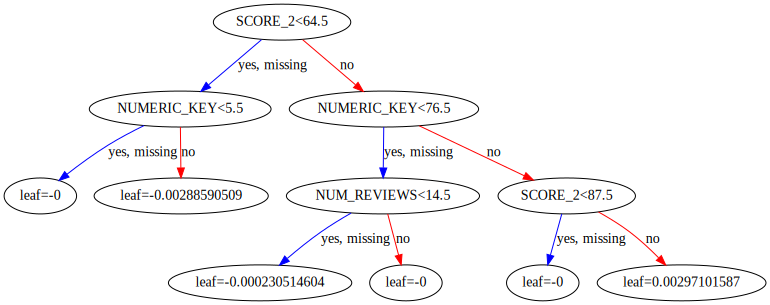

In [100]:
xgb.to_graphviz(generalized_model, num_trees=103)

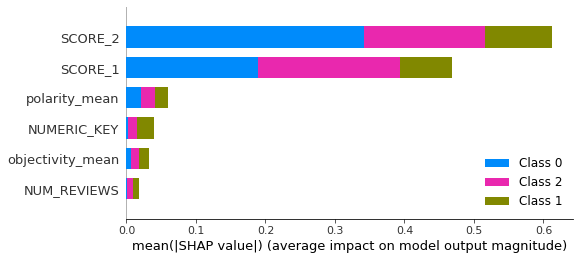

In [101]:
shap_explainer1 = shap.TreeExplainer(generalized_model)
shap_values1 = shap_explainer1.shap_values(X)
shap.summary_plot(shap_values1, X)

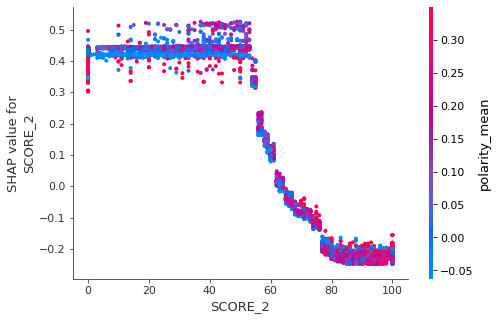

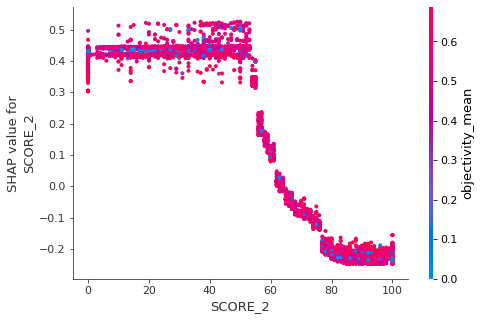

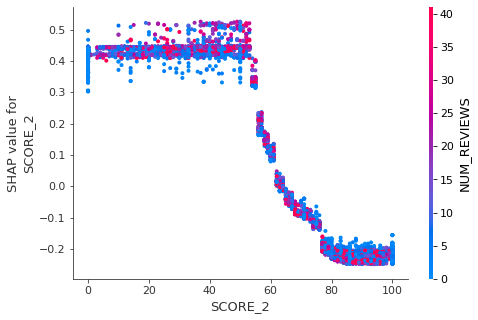

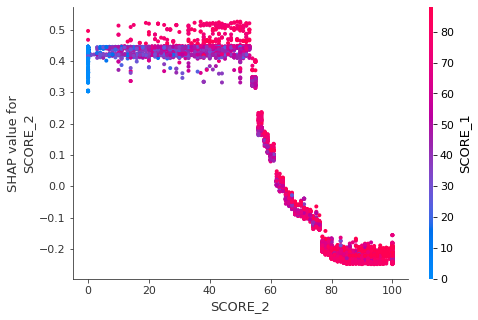

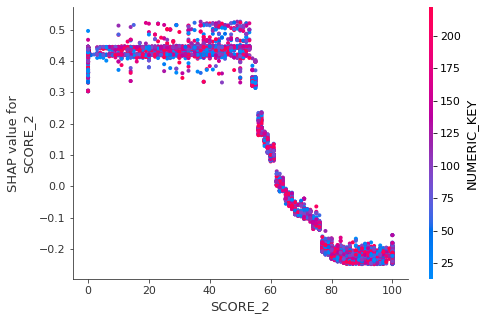

In [102]:
inds = shap.approximate_interactions("SCORE_2", shap_values1[0],X)
for i in range(5):
    shap.dependence_plot("SCORE_2", shap_values1[0], X, interaction_index=inds[i])

The hyperparameters and tuning for the generalized model trained and tested on a subset of random data is complete. The tuning of the regularization parameters alpha and lambda have significantly reduced the potential overfitting in earlier iterations whilst maintaining reasonably good auc scores indicating that while accuracy might have dropped on the test set and increased on the test set, the probability that the predictions made on both sets are accurate is fairly high. 

We see in this case that the model puts much more emphasis on SCORE_2 and SCORE_1 than the rest of the features. Interestingly enough, as the overal emphasis of a feature decreases with the model, more emphasis with those features is placed on classes 1 and 2.

In [133]:
pickle.dump(generalized_model, open("random_oscar.dat","wb")) #generalized_model pickled for later deployment

In [104]:
non_leo = full_df[full_df['ACTOR'] != 'Leonardo DiCaprio']
leo_set = full_df[full_df['ACTOR'] == 'Leonardo DiCaprio']

X_train_non, y_train_non = non_leo[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']], non_leo['AWARD']
X_test_leo, y_test_leo = leo_set[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']], leo_set['AWARD']

non_leo_wt = balancedWeights(y_train_non)

Pass classes=[0. 1. 2.], y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


### Prediction - generalized_model:

In [117]:
leo_preds_1 = generalized_model.predict(X_test_leo)
leo_proba_1 = generalized_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.balanced_accuracy_score(y_test_leo,leo_preds_1)))
print('AUC Score: {:.4}'.format(metrics.roc_auc_score(y_test_leo,leo_proba_1, average='weighted',multi_class='ovo')))
leo_useful = leo_set[['ROLE','TITLE','AWARD']]
leo_useful.reset_index(drop=True,inplace=True)
leo_pred_df = pd.DataFrame({'PREDICTION':leo_preds_1})
leo_pred_df.reset_index(drop=True, inplace=True)
leo_comparison = pd.concat([leo_useful, leo_pred_df],axis=1)
leo_comparison

Prediction accuracy: 32.05%
AUC Score: 0.715


,ROLE,TITLE,AWARD,PREDICTION
0,howard hughes,the aviator,1.0,1.0
1,danny archer,blood diamond,1.0,2.0
2,jordan belfort,the wolf of wall street,1.0,2.0
3,hugh glass,the revenant,2.0,1.0
4,rick dalton,once upon a time in hollywood,1.0,1.0
5,himself,spielberg,0.0,1.0
6,unknown,before the flood trailer,0.0,0.0
7,himself,before the flood,0.0,1.0
8,jay gatsby,the great gatsby,0.0,0.0
9,calvin candie,django unchained,0.0,2.0


### specified_model:
Here we retrain the model where the only information that is held out is DiCaprio's filmography as an actor. The model is retrained using the rest of the information with the correct weighting for the target values.

In [107]:
specified_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)


specified_model.fit(X_train_non, y_train_non, eval_set=[(X_train_non,y_train_non),(X_test_leo,y_test_leo)], sample_weight=non_leo_wt, early_stopping_rounds=50)

[0]	validation_0-merror:0.23786	validation_1-merror:0.58064
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.23510	validation_1-merror:0.58064
[2]	validation_0-merror:0.23111	validation_1-merror:0.54839
[3]	validation_0-merror:0.23445	validation_1-merror:0.54839
[4]	validation_0-merror:0.22546	validation_1-merror:0.54839
[5]	validation_0-merror:0.22590	validation_1-merror:0.51613
[6]	validation_0-merror:0.22771	validation_1-merror:0.51613
[7]	validation_0-merror:0.22176	validation_1-merror:0.51613
[8]	validation_0-merror:0.22401	validation_1-merror:0.51613
[9]	validation_0-merror:0.22633	validation_1-merror:0.51613
[10]	validation_0-merror:0.22546	validation_1-merror:0.51613
[11]	validation_0-merror:0.22249	validation_1-merror:0.51613
[12]	validation_0-merror:0.22184	validation_1-merror:0.51613
[13]	validation_0-merror:0.22249	validation_1-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=100,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

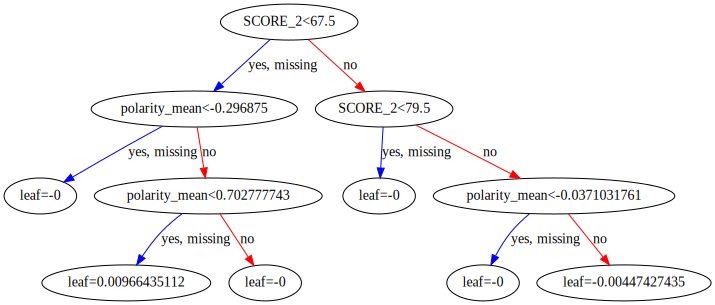

In [108]:
xgb.to_graphviz(specified_model, num_trees=15)

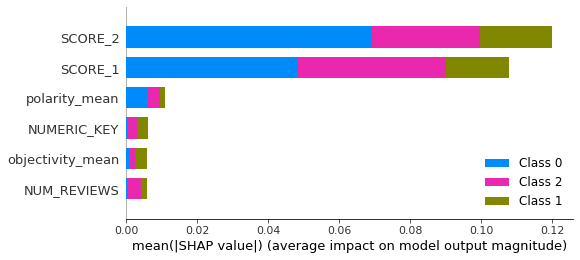

In [109]:
shap_explainer2 = shap.TreeExplainer(specified_model)
shap_values2 = shap_explainer2.shap_values(X_train_non)
shap.summary_plot(shap_values2, X_train_non)

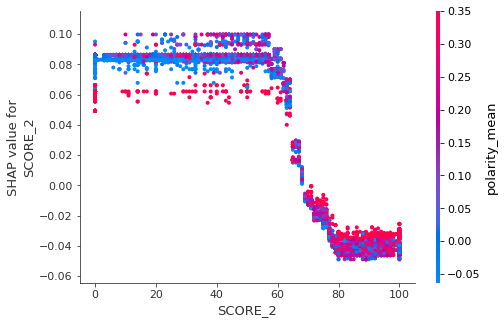

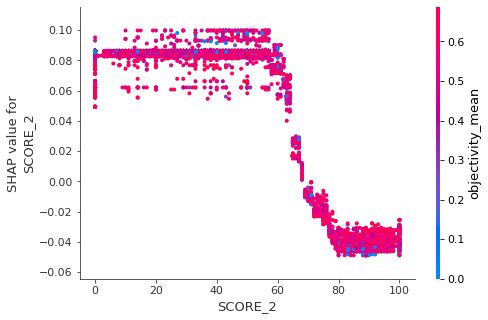

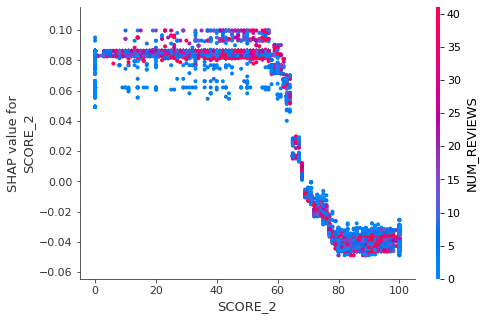

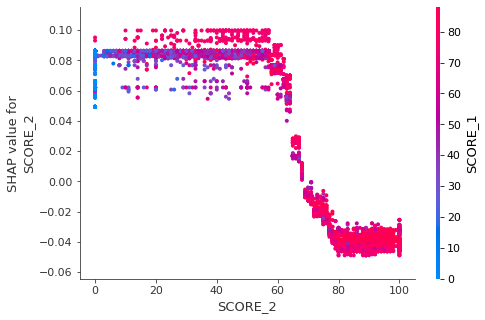

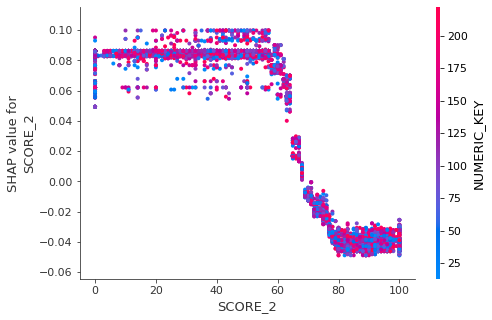

In [111]:
inds = shap.approximate_interactions("SCORE_2", shap_values2[0],X_train_non)
for i in range(5):
    shap.dependence_plot("SCORE_2", shap_values2[0], X_train_non, interaction_index=inds[i])

In [123]:
leo_preds_2 = specified_model.predict(X_test_leo)
leo_proba_2 = specified_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.balanced_accuracy_score(y_test_leo,leo_preds_2)))
print('AUC Score: {:.4}'.format(metrics.roc_auc_score(y_test_leo,leo_proba_2, average='weighted',multi_class='ovo')))
leo_useful2 = leo_set[['ROLE','TITLE','AWARD']]
leo_useful2.reset_index(drop=True,inplace=True)
leo_pred2_df = pd.DataFrame({'PREDICTION':leo_preds_2})
leo_pred2_df.reset_index(drop=True, inplace=True)
leo_comparison2 = pd.concat([leo_useful2, leo_pred2_df],axis=1)
leo_comparison2

Prediction accuracy: 66.67%
AUC Score: 0.7041


,ROLE,TITLE,AWARD,PREDICTION
0,howard hughes,the aviator,1.0,1.0
1,danny archer,blood diamond,1.0,2.0
2,jordan belfort,the wolf of wall street,1.0,2.0
3,hugh glass,the revenant,2.0,2.0
4,rick dalton,once upon a time in hollywood,1.0,1.0
5,himself,spielberg,0.0,2.0
6,unknown,before the flood trailer,0.0,0.0
7,himself,before the flood,0.0,1.0
8,jay gatsby,the great gatsby,0.0,0.0
9,calvin candie,django unchained,0.0,2.0


In [130]:
overall_comp = pd.merge(leo_comparison, leo_comparison2, how='outer', on=['ROLE','TITLE','AWARD'])

In [131]:
overall_comp

,ROLE,TITLE,AWARD,PREDICTION_x,PREDICTION_y
0,howard hughes,the aviator,1.0,1.0,1.0
1,danny archer,blood diamond,1.0,2.0,2.0
2,jordan belfort,the wolf of wall street,1.0,2.0,2.0
3,hugh glass,the revenant,2.0,1.0,2.0
4,rick dalton,once upon a time in hollywood,1.0,1.0,1.0
5,himself,spielberg,0.0,1.0,2.0
6,unknown,before the flood trailer,0.0,0.0,0.0
7,himself,before the flood,0.0,1.0,1.0
8,jay gatsby,the great gatsby,0.0,0.0,0.0
9,calvin candie,django unchained,0.0,2.0,2.0


Here PREDICTION_x and PREDICTION_y correspond to the predictions from the general_model and specified_model, respectively. We see in both cases an over prediction on the number of nominations and awards received for DiCaprio's various performances.